In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

In [15]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_anli.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Templated suffix (single-output)',
    'Avg suffix': 'Templated suffix',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(SUFFIX_LEGEND_REMAP)
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))


# drop results for other models, n_shots == 10, single-query ones.
suffix_results = suffix_results[
      (suffix_results["checkpoint"] == "EleutherAI/gpt-j-6B")
    & (suffix_results["n_shots"] < 10)
    & (suffix_results["use_single_query"] == "Avg suffix")
]

In [3]:
suffix_results[['checkpoint',  'task_name', 'n_shots']].value_counts()

checkpoint           task_name      n_shots
EleutherAI/gpt-j-6B  add_two        1          1
                                    5          1
                     subtract_two   1          1
                     square_one     5          1
                                    1          1
                     multiply_two   5          1
                                    1          1
                     max_two        5          1
                                    1          1
                     first_two      5          1
                                    1          1
                     fibonacci_one  5          1
                                    1          1
                     exp_one        5          1
                                    1          1
                     double_one     5          1
                                    1          1
                     divide_two     5          1
                                    1          1
                     subt

In [157]:
from typing import Dict


autoprompt_save_dir = '/home/johnmorris/interpretable-autoprompting/results/anli-intermediate'

raw_autoprompt_results = analyze_utils.load_results_and_cache_autoprompt_json(autoprompt_save_dir, save_file='r.pkl')
raw_autoprompt_results["legend"] = raw_autoprompt_results.apply(analyze_utils.get_legend__autoprompt, axis=1)
raw_autoprompt_results = raw_autoprompt_results[(raw_autoprompt_results["n_shots"] == 1)]
autoprompt_results = raw_autoprompt_results.groupby(['model_cls', 'task_name', 'n_shots', 'num_learned_tokens']).first().reset_index()
autoprompt_results = autoprompt_results

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 406.79it/s]


skipping /home/johnmorris/interpretable-autoprompting/results/anli-intermediate/Sep_25_11_57_dwtgmlqucavl/results.pkl (run still in progress?)
skipping /home/johnmorris/interpretable-autoprompting/results/anli-intermediate/Sep_25_12_11_dwtgmlqucavl/results.pkl (run still in progress?)
skipping /home/johnmorris/interpretable-autoprompting/results/anli-intermediate/Sep_26_08_44_dwtgmlqucavl/results.pkl (run still in progress?)


In [158]:
autoprompt_results["n_shots"].value_counts()

1    38
Name: n_shots, dtype: int64

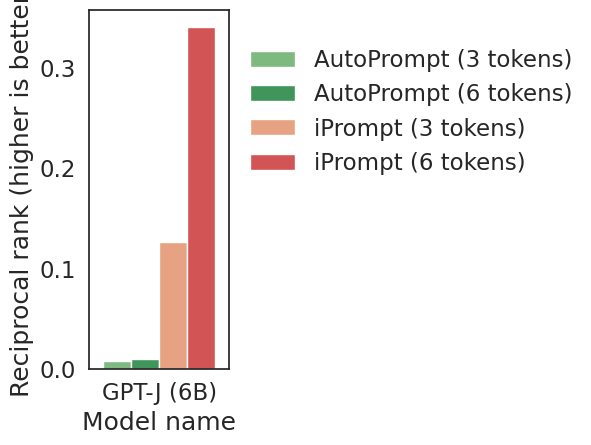

In [159]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (autoprompt_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

In [160]:
(
    raw_autoprompt_results[raw_autoprompt_results["prefixes__check_answer_func"]]
        .groupby(["legend", "task_name", "n_shots"])[["reciprocal_rank", "prefixes", "max_digit"]].first()
)

reciprocal_rank  \
legend                task_name                          n_shots                    
AutoPrompt (3 tokens) task1147_country_currency          1               0.071429   
AutoPrompt (6 tokens) task1147_country_currency          1               0.090909   
iPrompt (3 tokens)    task092_check_prime_classification 1               0.058824   
                      task107_splash_question_to_sql     1               0.200000   
                      task1147_country_currency          1               1.000000   
                      task1509_evalution_antonyms        1               0.010417   
iPrompt (6 tokens)    task088_identify_typo_verification 1               0.200000   
                      task092_check_prime_classification 1               0.016667   
                      task107_splash_question_to_sql     1               1.000000   
                      task1146_country_capital           1               0.142857   
                      task1147_country_currency          1               1.000000   
                      task1509_evalution_antonyms        1               1.000000   
                      task183_rhyme_generation           1               0.047619   

                                                                                              prefixes  \
legend                task_name                          n_shots                                         
AutoPrompt (3 tokens) task1147_country_currency          1                     cryptocurrencytheperiod   
AutoPrompt (6 tokens) task1147_country_currency          1             renciesthethe currencythe mortg   
iPrompt (3 tokens)    task092_check_prime_classification 1                            Does every prime   
                      task107_splash_question_to_sql     1                                     In SQL,   
                      task1147_country_currency          1                          Currency Converter   
                      task1509_evalution_antonyms        1                         answer the opposite   
iPrompt (6 tokens)    task088_identify_typo_verification 1                  How do you spell that word   
                      task092_check_prime_classification 1                Do the number contain prime?   
                      task107_splash_question_to_sql     1              Write an SQL to produce output   
                      task1146_country_capital           1         Select the country whose capital is   
                      task1147_country_currency          1              Select currency code for a new   
                      task1509_evalution_antonyms        1                   What is the opposite of 1   
                      task183_rhyme_generation           1                  Enter one word that rhymes   

                                                                  max_digit  
legend                task_name                          n_shots             
AutoPrompt (3 tokens) task1147_country_currency          1               10  
AutoPrompt (6 tokens) task1147_country_currency          1               10  
iPrompt (3 tokens)    task092_check_prime_classification 1               10  
                      task107_splash_question_to_sql     1               10  
                      task1147_country_currency          1               10  
                      task1509_evalution_antonyms        1               10  
iPrompt (6 tokens)    task088_identify_typo_verification 1               10  
                      task092_check_prime_classification 1               10  
                      task107_splash_question_to_sql     1               10  
                      task1146_country_capital           1               10  
                      task1147_country_currency          1               10  
                      task1509_evalution_antonyms        1               10  
                      task183_rhyme_generation           1               10

In [161]:
raw_autoprompt_results

,model_cls,batch_size,seed,n_epochs,max_n_steps,max_n_datapoints,train_split_frac,max_dset_size,early_stopping_steps,max_digit,...,test_start_time,prefix_test_loss,prefix_test_acc,num_prefixes_used_for_test,test_end_time,test_time_elapsed,pickle_filename,final_answer_pos_initial_token,reciprocal_rank,legend
0,genetic,32,1,100,10000000000,10000,0.75,10000,50,10,...,1.664132e+09,0.249067,0.086207,128.0,1.664132e+09,33.756044,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,iPrompt (3 tokens)
1,genetic,32,1,100,10000000000,10000,0.75,10000,50,10,...,1.664132e+09,0.251899,0.103448,128.0,1.664132e+09,33.756044,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,iPrompt (3 tokens)
2,genetic,32,1,100,10000000000,10000,0.75,10000,50,10,...,1.664132e+09,0.250261,0.103448,128.0,1.664132e+09,33.756044,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,iPrompt (3 tokens)
3,genetic,32,1,100,10000000000,10000,0.75,10000,50,10,...,1.664132e+09,0.252421,0.137931,128.0,1.664132e+09,33.756044,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,iPrompt (3 tokens)
4,genetic,32,1,100,10000000000,10000,0.75,10000,50,10,...,1.664132e+09,0.246011,0.086207,128.0,1.664132e+09,33.756044,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,iPrompt (3 tokens)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,autoprompt,32,1,100,10000000000,10000,0.75,10000,50,10,...,NaN,NaN,NaN,NaN,NaN,NaN,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,AutoPrompt (6 tokens)
124,autoprompt,32,1,100,10000000000,10000,0.75,10000,50,10,...,NaN,NaN,NaN,NaN,NaN,NaN,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,AutoPrompt (6 tokens)
125,autoprompt,32,1,100,10000000000,10000,0.75,10000,50,10,...,NaN,NaN,NaN,NaN,NaN,NaN,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,AutoPrompt (6 tokens)
126,autoprompt,32,1,100,10000000000,10000,0.75,10000,50,10,...,NaN,NaN,NaN,NaN,NaN,NaN,/home/johnmorris/interpretable-autoprompting/r...,10000000000,1.000000e-10,AutoPrompt (6 tokens)


In [162]:
1/59

0.01694915254237288

In [163]:
raw_autoprompt_results[
    # (raw_autoprompt_results["prefix_n_queries"] > 50) & 
    (raw_autoprompt_results["num_learned_tokens"] == 6) & 
    (raw_autoprompt_results["task_name"] == "task092_check_prime_classification")
][["prefixes", "prefix_train_loss", "prefixes__check_answer_func", "final_answer_pos_initial_token", "prefix_n_queries"]].iloc[:10]

,prefixes,prefix_train_loss,prefixes__check_answer_func,final_answer_pos_initial_token,prefix_n_queries
0,Yes or no? Is that,7.660798,False,59,5
1,Yes or no. The first,7.753990,False,59,8
2,Can I use the phrase?,8.010605,False,59,4
3,Yes or No? The,8.087547,False,59,11
4,"Yes or No, input a",8.089742,False,59,5
5,Yes or no?(press,8.097787,False,59,4
6,Yes or No Output on,8.103601,False,59,7
7,Yes or No? (P,8.111238,False,59,8
8,Yes or no questions are better,8.115526,False,59,6
9,Yes to yes or No for,8.117228,False,59,4


In [173]:
pd.set_option('display.max_rows', 100)
raw_autoprompt_results[raw_autoprompt_results["prefixes__check_answer_func"]].groupby(["legend", "task_name", "n_shots"])[["reciprocal_rank", "prefixes", "max_digit", "prefix_n_queries"]].first()

reciprocal_rank  \
legend                task_name                          n_shots                    
AutoPrompt (3 tokens) task1147_country_currency          1               0.071429   
AutoPrompt (6 tokens) task1147_country_currency          1               0.090909   
iPrompt (3 tokens)    task092_check_prime_classification 1               0.058824   
                      task107_splash_question_to_sql     1               0.200000   
                      task1147_country_currency          1               1.000000   
                      task1509_evalution_antonyms        1               0.010417   
iPrompt (6 tokens)    task088_identify_typo_verification 1               0.200000   
                      task092_check_prime_classification 1               0.016667   
                      task107_splash_question_to_sql     1               1.000000   
                      task1146_country_capital           1               0.142857   
                      task1147_country_currency          1               1.000000   
                      task1509_evalution_antonyms        1               1.000000   
                      task183_rhyme_generation           1               0.047619   

                                                                                              prefixes  \
legend                task_name                          n_shots                                         
AutoPrompt (3 tokens) task1147_country_currency          1                     cryptocurrencytheperiod   
AutoPrompt (6 tokens) task1147_country_currency          1             renciesthethe currencythe mortg   
iPrompt (3 tokens)    task092_check_prime_classification 1                            Does every prime   
                      task107_splash_question_to_sql     1                                     In SQL,   
                      task1147_country_currency          1                          Currency Converter   
                      task1509_evalution_antonyms        1                         answer the opposite   
iPrompt (6 tokens)    task088_identify_typo_verification 1                  How do you spell that word   
                      task092_check_prime_classification 1                Do the number contain prime?   
                      task107_splash_question_to_sql     1              Write an SQL to produce output   
                      task1146_country_capital           1         Select the country whose capital is   
                      task1147_country_currency          1              Select currency code for a new   
                      task1509_evalution_antonyms        1                   What is the opposite of 1   
                      task183_rhyme_generation           1                  Enter one word that rhymes   

                                                                  max_digit  \
legend                task_name                          n_shots              
AutoPrompt (3 tokens) task1147_country_currency          1               10   
AutoPrompt (6 tokens) task1147_country_currency          1               10   
iPrompt (3 tokens)    task092_check_prime_classification 1               10   
                      task107_splash_question_to_sql     1               10   
                      task1147_country_currency          1               10   
                      task1509_evalution_antonyms        1               10   
iPrompt (6 tokens)    task088_identify_typo_verification 1               10   
                      task092_check_prime_classification 1               10   
                      task107_splash_question_to_sql     1               10   
                      task1146_country_capital           1               10   
                      task1147_country_currency          1               10   
                      task1509_evalution_antonyms        1               10   
                      task183_rhyme_generation           1               10   

             

In [174]:
r = pd.concat((suffix_results, autoprompt_results), axis=0)

In [175]:
tn = r[["task_name"]].value_counts().reset_index()
finished_task_names = tn[tn[0]==tn[0].max()]["task_name"].tolist()
rf = r[r["task_name"].map(lambda t: t in finished_task_names)] # r_finished

In [176]:
len(r), len(rf)

(58, 54)

In [177]:
len(suffix_results), len(autoprompt_results)

(20, 38)

In [178]:
autoprompt_results.groupby(['model_cls', 'n_shots', 'task_name'])['reciprocal_rank'].mean()

model_cls   n_shots  task_name                                                  
autoprompt  1        task088_identify_typo_verification                             1.000000e-10
                     task092_check_prime_classification                             1.000000e-10
                     task1146_country_capital                                       1.000000e-10
                     task1147_country_currency                                      8.116883e-02
                     task1149_item_check_edible                                     1.000000e-10
                     task1191_food_veg_nonveg                                       1.000000e-10
                     task1336_peixian_equity_evaluation_corpus_gender_classifier    1.000000e-10
                     task1509_evalution_antonyms                                    1.000000e-10
                     task183_rhyme_generation                                       1.000000e-10
genetic     1        task088_identify_typo_ver

## Save prompts to a file

In [205]:
METHOD_REMAP = {
    'autoprompt': 'autoprompt',
    'genetic': 'iprompt'
}
autoprompt_results['method'] = 
autoprompt_results[autoprompt_results["num_learned_tokens"] == 6].groupby(['model_cls', 'task_name']).first().reset_index()[['model_cls', 'prefixes', 'task_name']].pivot(index='task_name', columns='model_cls')

prefixes  \
model_cls                                                                    autoprompt   
task_name                                                                                 
task088_identify_typo_verification                                    Sytheanathethethe   
task092_check_prime_classification                   Abedin AnywaytheONSORED Roses 2050   
task107_splash_question_to_sql                                                      NaN   
task1146_country_capital                                     Bringingthethe Stargthethe   
task1147_country_currency                                 renciesthethe Dmitrythe mortg   
task1149_item_check_edible                              joiningthe Brazil fuckingthethe   
task1191_food_veg_nonveg                                             Novthethethethethe   
task1336_peixian_equity_evaluation_corpus_gende...             TurtheFortthetheReviewer   
task1509_evalution_antonyms                            prevailingthethe weakestthe wins   
task183_rhyme_generation                                matesthe dex championshipthethe   

                                                                                             
model_cls                                                                           genetic  
task_name                                                                                    
task088_identify_typo_verification                   Given a string containing the alphabet  
task092_check_prime_classification                                       Yes or no? Is that  
task107_splash_question_to_sql                               Write an SQL to produce output  
task1146_country_capital                                     How did the economy perform in  
task1147_country_currency                                    Select currency code for a new  
task1149_item_check_edible                                          Would you like to buy a  
task1191_food_veg_nonveg                                                 yes or no? This is  
task1336_peixian_equity_evaluation_corpus_gende...                               A B C D F#  
task1509_evalution_antonyms                                       What is the opposite of 1  
task183_rhyme_generation                                                     bale balbalbab

## Measure best method

In [179]:
TASK_RENAME = {
    'task1191_food_veg_nonveg': 'Check vegetarian',
    'task1509_evalution_antonyms': 'Antonyms',
    'task1147_country_currency': 'Country currency',
    'task088_identify_typo_verification': 'Find typo',
    'task1146_country_capital': 'Country capital',
    'task183_rhyme_generation': 'Rhyme generation',
    'task107_splash_question_to_sql': 'SQL query generation',
    'task1336_peixian_equity_evaluation_corpus_gender_classifier': 'Gender classification',
    'task092_check_prime_classification': 'Check prime',
    'task1149_item_check_edible': 'Check edibility',
}

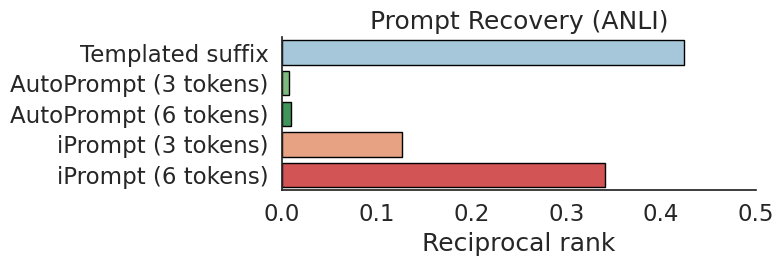

In [190]:
import seaborn as sns
sns.set_theme(font_scale=1.5, style="white")
for metric_key in [
                 'reciprocal_rank',
                #  'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    tab = (
        (r[r['n_shots'] == 1]
            # (mean over templates, task_name)
            .groupby(['legend'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    hue_order = analyze_utils.get_hue_order(tab['legend'])
    
    g = sns.catplot(
        kind='bar',
        data=tab,
        x='reciprocal_rank',
        y='legend',
        hue='legend',
        order=hue_order,
        hue_order=hue_order,
        palette=analyze_utils.COLORS,
        edgecolor='black',
        orient='h',
        legend=False,
        # figsize=(15,9)
        dodge=False, # make the bars nice and snug
    )
    # for ax in g.axes.flat:
    #     ax.set_xticks([])
    g.fig.set_figwidth(8)
    g.fig.set_figheight(3)
    plt.xlim((0.0, 0.5))
    plt.xlabel('Reciprocal rank')
    plt.ylabel('')
    plt.title('Prompt Recovery (ANLI)')
    # plt.legend(False)
    plt.tight_layout()
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_anli_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_anli_{metric_key}.pkl')
    plt.show()

### Plot the best model

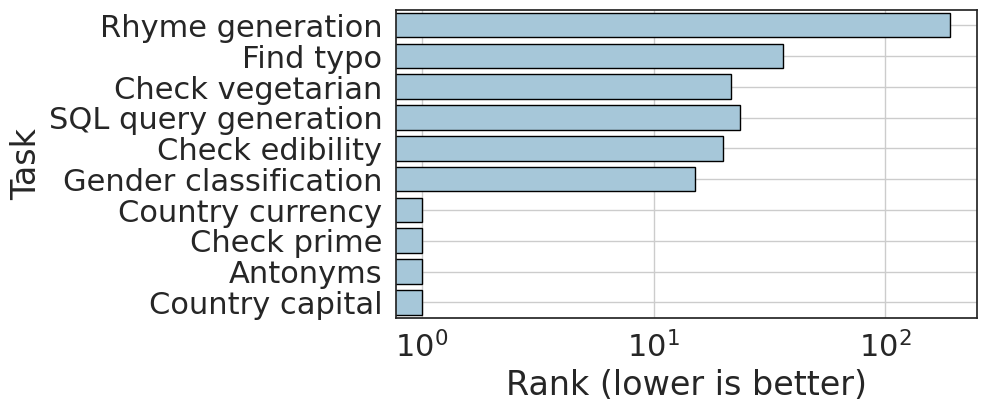

In [183]:
TASK_RENAME = {
    'task1191_food_veg_nonveg': 'Check vegetarian',
    'task1509_evalution_antonyms': 'Antonyms',
    'task1147_country_currency': 'Country currency',
    'task088_identify_typo_verification': 'Find typo',
    'task1146_country_capital': 'Country capital',
    'task183_rhyme_generation': 'Rhyme generation',
    'task107_splash_question_to_sql': 'SQL query generation',
    'task1336_peixian_equity_evaluation_corpus_gender_classifier': 'Gender classification',
    'task092_check_prime_classification': 'Check prime',
    'task1149_item_check_edible': 'Check edibility',
}


r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(
        data=model_results, y=model_results['task_name'].map(TASK_RENAME), x='rank', color=analyze_utils.COLORS[legend_name],
        edgecolor='black',
        errorbar=None
    ) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Templated suffix')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

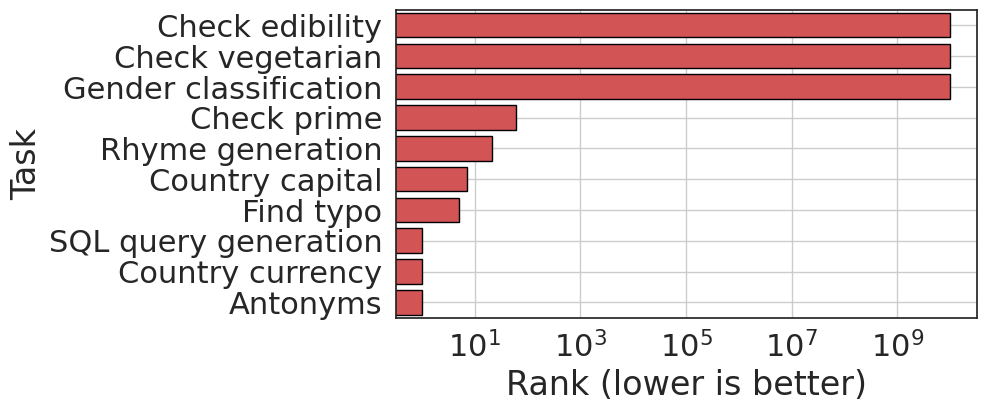

In [185]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(
        data=model_results, y=model_results['task_name'].map(TASK_RENAME), x='rank', color=analyze_utils.COLORS[legend_name],
        edgecolor='black',
        errorbar=None,
    ) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='iPrompt (6 tokens)')
# plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')